In [ ]:
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pandas.plotting import autocorrelation_plot


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#  Data Preperation


Get Data and Initialize Dataframe  

In [ ]:
sns.set(color_codes=True)

data = pd.read_csv("superstore-data.zip",encoding="latin1", compression="zip")



## Prepare

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Market          51290 non-null  object 
 12  Region          51290 non-null  object 
 13  Product ID      51290 non-null  object 
 14  Category        51290 non-null  object 
 15  Sub-Category    51290 non-null  object 
 16  Product Name    51290 non-null  object 
 17  Sales           51290 non-null 

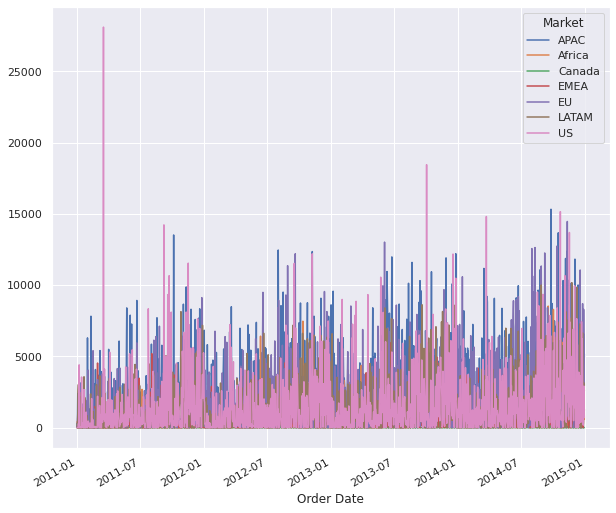

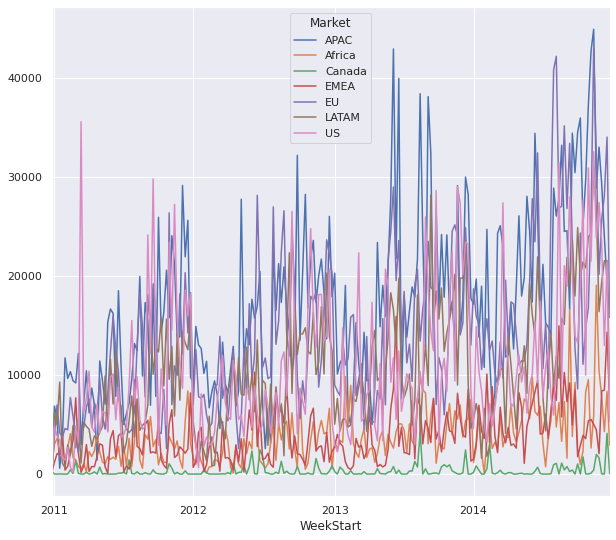

In [ ]:
#%% LIBRARIES
data.drop(["Postal Code"],axis=1, inplace=True)
#%%
print(data.info()) 
data["Order Date"]= data["Order Date"].apply(lambda row: row.replace("/","-"))

data["Order Date"] = pd.to_datetime(data["Order Date"],format="%d-%m-%Y")

data["WeekStart"] = data["Order Date"] - data["Order Date"].dt.weekday * timedelta(days=1)

 
daily= pd.pivot_table(data,values="Sales",index=["Order Date"],columns=["Market"],aggfunc=np.sum).fillna(0)

print(daily)

weekly= pd.pivot_table(data,values="Sales",index=["WeekStart"],columns=["Market"],aggfunc=np.sum).fillna(0)
weeklystd = pd.pivot_table(data,values="Sales",index=["WeekStart"],columns=["Market"],aggfunc=np.std).fillna(0)
weeklyavg = pd.pivot_table(data,values="Sales",index=["WeekStart"],columns=["Market"],aggfunc=np.average).fillna(0)
print(weekly)
 
daily.plot(figsize=((10,9)))
weekly.plot(figsize=((10,9)))



Choosing market

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


Market              APAC       Africa  ...         LATAM            US
WeekStart                              ...                            
2010-12-27     22.749937     6.362645  ...           inf           inf
2011-01-03     -0.178025     0.199953  ... -2.043111e-01 -1.966010e-01
2011-01-10     -0.895436    -0.367045  ...  8.557269e-01 -1.106889e-01
2011-01-17      4.693858    -0.349950  ... -8.824563e-01 -5.428178e-01
2011-01-24      2.492935    -0.035734  ... -4.115913e-01 -8.301840e-02
...                  ...          ...  ...           ...           ...
2014-12-01     -0.112156    -0.251304  ...  1.812548e-01 -1.504116e-01
2014-12-08     -0.183547    -0.451749  ...  1.116871e-01 -4.418050e-01
2014-12-15     -0.189932     0.947935  ...  4.716605e-04  6.474175e-01
2014-12-22  19405.702500  8347.776000  ...  2.157025e+04  2.143395e+04
2014-12-29  15833.886300  2912.661000  ...  8.554769e+03  5.286675e+03

[210 rows x 7 columns]


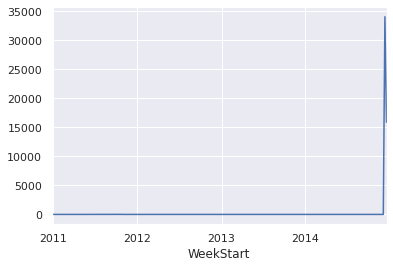

In [ ]:
#%% 
_market = "EU" 
time_dif_data = weekly.copy()

for col in time_dif_data.columns:
    for i in range(0,time_dif_data.shape[0]-2):
        row = time_dif_data[col]
        row[i]=(row[i+1]-row[i])/row[i] #Yüzdelik


print(time_dif_data)
time_dif_data[_market].plot()

def hob(column,data,title):
    b = data.copy()
    b["indexes"] = np.arange(data[column].size)
    plt.plot_date(data.index,data[column])
    plt.xticks(rotation=90)
    plt.figure(figsize=(9,9)) 
    plt.title(title)
    return b[column]
    


Getting statistical values

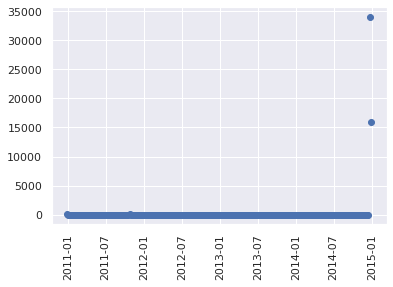

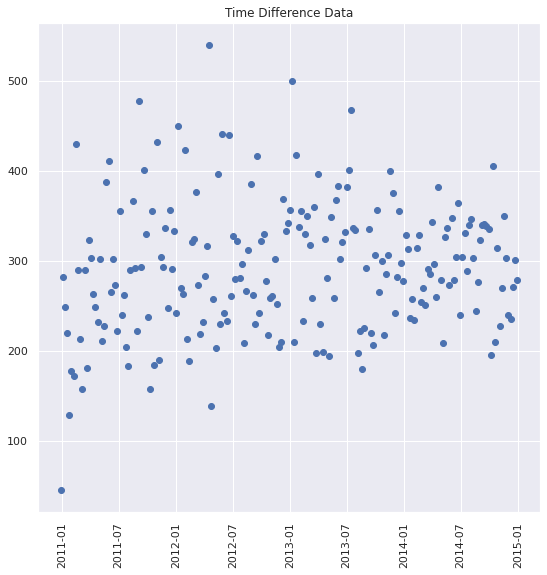

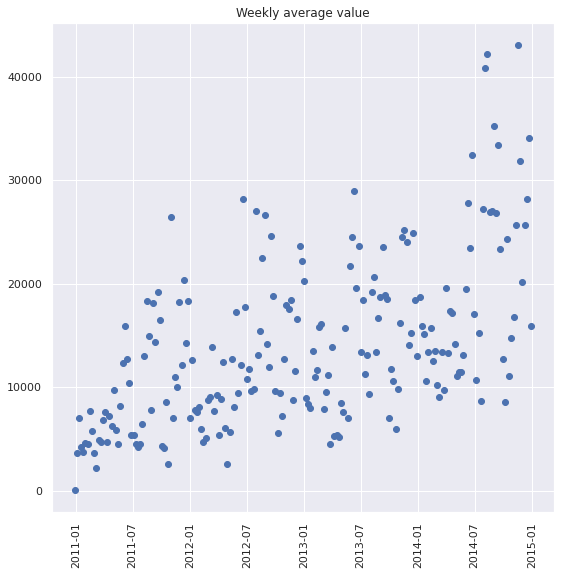

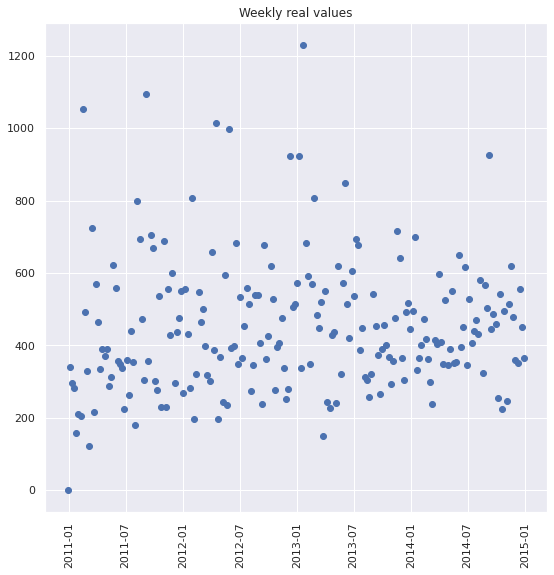

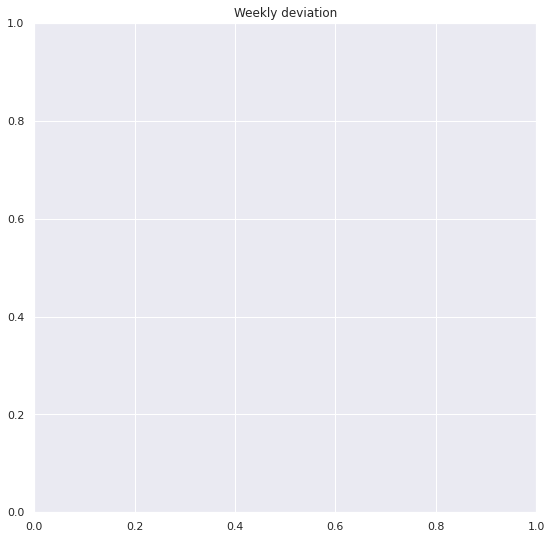

In [ ]:
#%%
def minmax(arr):
    return (arr-min(arr))/(max(arr)-min(arr))


diff= hob(_market,time_dif_data,"Time Difference Data")
avg = hob(_market,weeklyavg,"Weekly average value")
real= hob(_market,weekly,"Weekly real values")
std = hob(_market,weeklystd,"Weekly deviation")

#std  = minmax(std)
#diff = minmax(avg)
#real = minmax(real)



# Training, Testing and Forecating

Train and Test function

In [ ]:
#%%
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RANSACRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
#•from pyearth import Earth
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

WINDOW_SIZE=5

"""1. Grdient Boost Tree
   2. Random Forest Regression
   3. Linear Regression
   4. Decision Tree Regression
   5. Kernel Ridge
   6. Neural Network
   7. Ridge Regression
   8. Lasso Regression
   9. Ransac Regressor
   10. Extra Tree Regressor
   """
def TrainNTest(x_train,y_train,x_test,y_test,max_features,model="GBT"):
    if(model=="GBT"):
        learning_rates = [0.00001,0.0001,0.001, 0.1, 1]
        best = -100
        
        for learning_rate in learning_rates:
            gb = GradientBoostingRegressor(n_estimators=50, learning_rate =learning_rate, 
                                           max_features=max_features, max_depth = 50, 
                                           random_state = 42).fit(x_train,y_train)
            score = gb.score(x_test,y_test)
            if(score>best):
                bestmodel= gb
    elif(model=="RFR"):
        bestmodel=RandomForestRegressor(max_depth=100, random_state=0,n_estimators=300).fit(x_train,y_train)
    elif(model=="LR"):
        bestmodel= LinearRegression().fit(x_train,y_train)
    elif(model=="R"):
        bestmodel = Ridge().fit(x_train,y_train)
    elif(model=="RANSAC"):
        bestmodel = RANSACRegressor().fit(x_train,y_train)    
    elif(model=="L"):
        bestmodel = Lasso().fit(x_train,y_train)
    elif(model=="DTR"):
        bestmodel = DecisionTreeRegressor().fit(x_train,y_train)
    elif(model=="ETR"):
        bestmodel = ExtraTreeRegressor().fit(x_train,y_train)        
    elif(model=="KR"):
        bestmodel = KernelRidge().fit(x_train,y_train)
    elif(model=="NN"):
        x_train_reshaped = x_train.reshape((x_train.shape[0],4,int(max_features/4)))
        x_test_reshaped = x_test.reshape((x_test.shape[0],4,int(max_features/4)))
        bestmodel = Sequential()
        bestmodel.add(LSTM(128,input_shape=(4,int(max_features/4))))
        bestmodel.add(Dropout(0.5))
        bestmodel.add(Dense(16))
        bestmodel.add(Dense(1))
        bestmodel.compile( loss='mean_squared_error',optimizer="adam")
        bestmodel.fit(x_train_reshaped, y_train,epochs=7000,batch_size=189,
                            validation_data=(x_test_reshaped,y_test),verbose=1,shuffle=True)
    if(model=="NN"):
        score = r2_score(y_test,bestmodel.predict(x_test_reshaped))
        scoremean = mean_absolute_error(y_test, bestmodel.predict(x_test_reshaped))
        plt.plot(bestmodel.predict(x_test_reshaped))
    else:
        plt.plot(bestmodel.predict(x_test))
        score = bestmodel.score(x_test,y_test) 
        scoremean = mean_absolute_error(y_test,bestmodel.predict(x_test))
    plt.plot(y_test)
    plt.legend(["predicted","real"])
    plt.title(model)
    plt.show()
    print("{} r2 Score: {}, absolute mean error: {}".format(model,score,scoremean))
    return score,scoremean






### Applying Machine Learning Regression Models

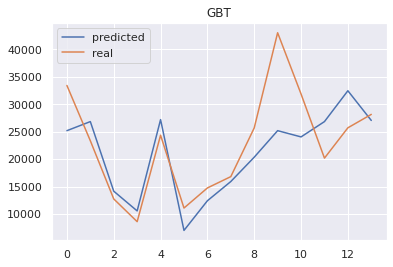

GBT r2 Score: 0.4866356725897017, absolute mean error: 5054.550964285708


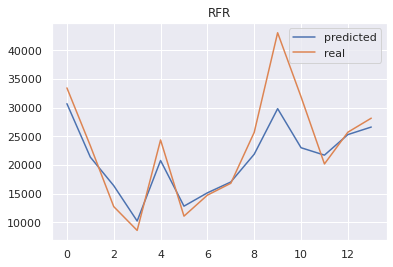

RFR r2 Score: 0.7362857354899597, absolute mean error: 3239.1072060714314


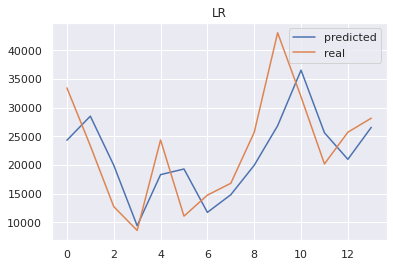

LR r2 Score: 0.4580535769391531, absolute mean error: 5704.356806102044


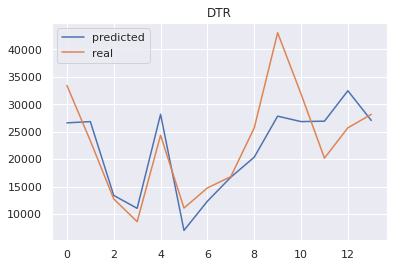

DTR r2 Score: 0.6007785116013626, absolute mean error: 4567.998214285711


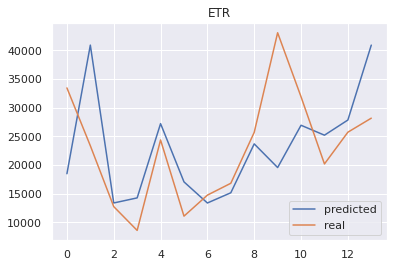

ETR r2 Score: -0.1523914307131189, absolute mean error: 7207.943142857145


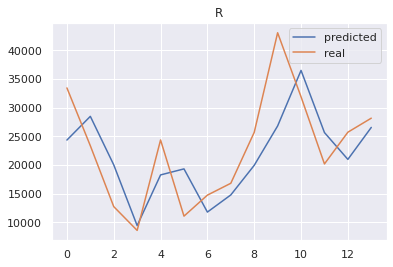

R r2 Score: 0.45632409641286353, absolute mean error: 5713.816174457991


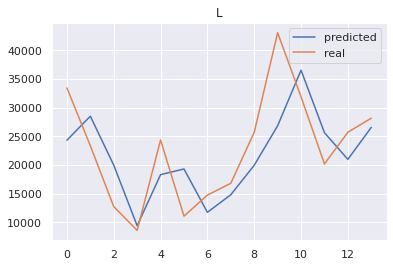

L r2 Score: 0.4579532439586095, absolute mean error: 5704.677663526364


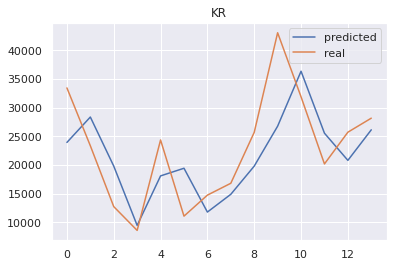

KR r2 Score: 0.4475163947661496, absolute mean error: 5770.757072544641


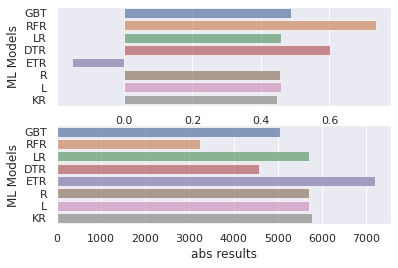

In [ ]:
 
def setTrain(window_size,size):
        
    X = np.zeros((size-window_size,4*window_size),dtype="float")
    Y = np.zeros((size-window_size),dtype="float")
    for i in range(size-window_size):
        X[i]= np.array([std[i:i+window_size].values,diff[i:i+window_size].values, avg[i:i+window_size].values,real[i:i+window_size].values]).reshape((4*window_size,))
        Y[i]= real[i+window_size]
    return X,Y

X,Y=setTrain(WINDOW_SIZE,208)

trainSize=189
x_train = X[:trainSize]
y_train = Y[:trainSize]
x_test = X[trainSize:]
y_test = Y[trainSize:]

scores = []
scoresabs = []
labels= ["GBT","RFR","LR","DTR","ETR","R","L","KR"]
#Try All Machine Learning Regression Models
for model in labels:
    a,b = TrainNTest(x_train,y_train,x_test,y_test,4*(WINDOW_SIZE),model)
    scores.append(a)
    scoresabs.append(b)
    
results = pd.DataFrame(data = {"results": scores, "ML Models":labels})
resultsabs = pd.DataFrame(data = {"abs results": scoresabs, "ML Models":labels})
fig,axes = plt.subplots(2,1)
sns.barplot(x="results",y="ML Models",data=results,alpha=0.7, ax = axes[0])
sns.barplot(x="abs results",y="ML Models",data=resultsabs,alpha=0.7, ax=axes[1])




Changing data with statistical changes with past

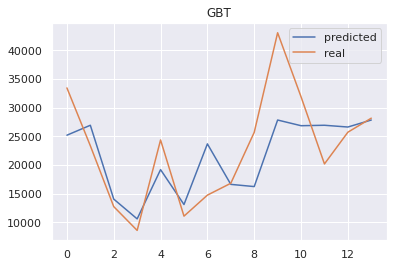

GBT r2 Score: 0.5093492302211171, absolute mean error: 4933.830964285712


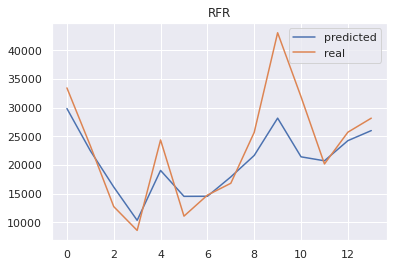

RFR r2 Score: 0.6470363357195925, absolute mean error: 3801.6535182142884


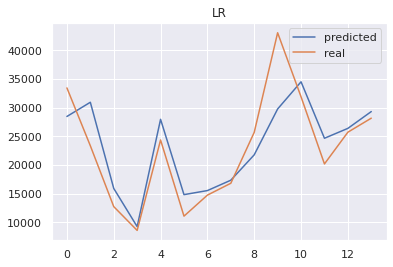

LR r2 Score: 0.7161416188788594, absolute mean error: 3652.664763245603


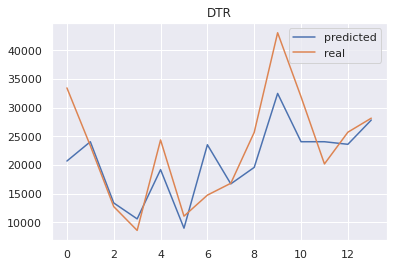

DTR r2 Score: 0.5791871988446087, absolute mean error: 4501.464642857141


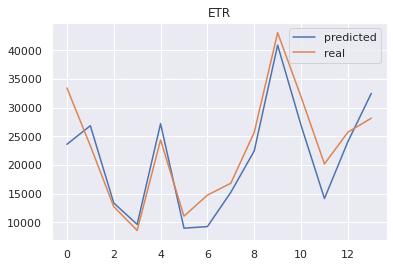

ETR r2 Score: 0.7895926882243804, absolute mean error: 3523.7368928571377


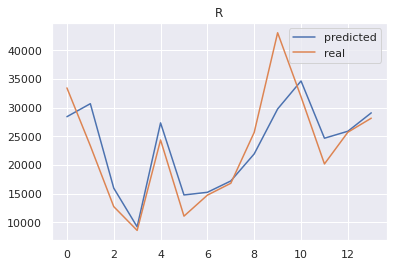

R r2 Score: 0.7239701001424106, absolute mean error: 3506.745959167671


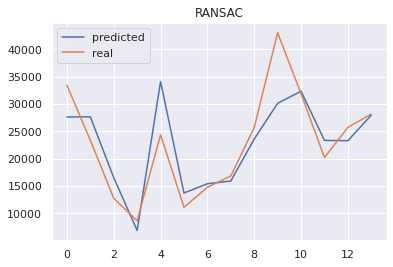

RANSAC r2 Score: 0.7005446599372877, absolute mean error: 3625.9209304535498


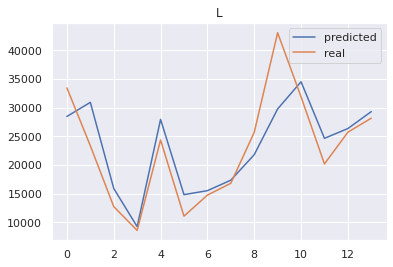

L r2 Score: 0.7168854814578025, absolute mean error: 3643.777540535716


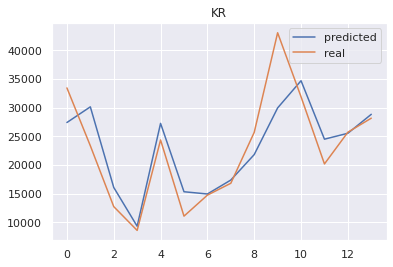

KR r2 Score: 0.7216524141014278, absolute mean error: 3550.1928777901776


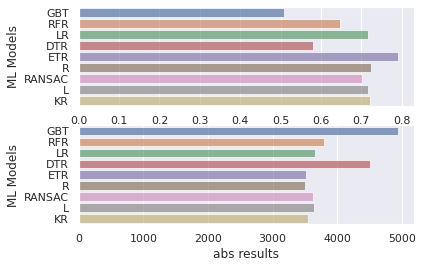

In [ ]:
 
def setTrainWithPastYear(window_size,size):
    X = np.zeros((size-52,4*(window_size+1)),dtype="float")
    Y = np.zeros((size-52),dtype="float")
    for i in range(size-52):
        X[i]= np.array([np.insert( std [i+52-window_size:i+52].values , 0 , std [i]),
                        np.insert( diff[i+52-window_size:i+52].values , 0 , diff[i]),
                        np.insert( avg [i+52-window_size:i+52].values , 0 , avg [i]),
                        np.insert( real[i+52-window_size:i+52].values , 0 , real[i])
                        ]).reshape((4*(window_size+1),))
        Y[i]= real[i+52]
        
    return X,Y

X, Y = setTrainWithPastYear(WINDOW_SIZE,208 )

trainSize=142
x_train = X[:trainSize]
y_train = Y[:trainSize]
x_test = X[trainSize:]
y_test = Y[trainSize:]

scores = []
scoresabs = []
labels= ["GBT","RFR","LR","DTR","ETR","R","RANSAC","L","KR"]

for model in labels:
    a,b  = TrainNTest(x_train,y_train,x_test,y_test,4*(WINDOW_SIZE+1),model)
    scores.append(a)
    scoresabs.append(b)

results = pd.DataFrame(data = {"results": scores, "ML Models":labels})
resultsabs = pd.DataFrame(data = {"abs results": scoresabs, "ML Models":labels})
fig,axes = plt.subplots(2,1)
sns.barplot(x="results",y="ML Models",data=results,alpha=0.7, ax = axes[0])
sns.barplot(x="abs results",y="ML Models",data=resultsabs,alpha=0.7, ax=axes[1]) 
    


Applying statistical models for forecasting

In [ ]:
# array.autocorr(Lag=53) yazdığındaa 53 indexte bir ne kadar korelasyon olduğunu söylüyor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import r2_score

"""ARIMA MODEL"""


""" Autokorelasyondan anlaşıldığı kadarıyla EN YÜKSEK 53. lagda çıkıyor bu yüzden ARIMA modelindeki
    p parametresi (lag order) 53 ile başlamalı,
    difference of order: 1"""
#daily = daily[_market]
forecastData = daily[_market]


Autocorrelation plot for data

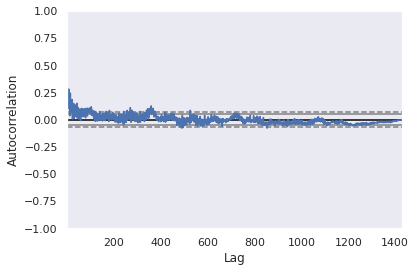

In [ ]:
autocorrelation_plot(forecastData) 

### Training Autoregressive Integrated Moving Average with Explanatory Variable aka ARIMAX to forecast

In [ ]:
decompose = seasonal_decompose(forecastData,model="additive",freq=365).plot() #Yıllık olarak dalganın aayrıştıırlması 
"""Trend var, trend quadratic değil lineer ->   """

y_train = forecastData[:1360]
y_test = forecastData[len(y_train):]
predictions = []
history = [y for y in y_train]
for t in range(len(y_test)):
	model = ARIMA(history,order=(0,1,1))
	model_fit = model.fit(disp=0)
	yhat=  model_fit.forecast()[0]
	predictions.append(yhat)
	obs = y_test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)
print("R2 score: ",r2_score(y_test,predictions))

# plot
plt.plot(y_test.values)
plt.plot(predictions, color='red')
plt.show()





predicted=2679.244845, expected=1379.389500
predicted=2596.648654, expected=2471.130000
predicted=2589.998779, expected=2703.813000
predicted=2598.746939, expected=0.000000
predicted=2431.715689, expected=2471.281500
predicted=2435.677383, expected=3522.240000
predicted=2507.846303, expected=2071.542000
predicted=2481.280573, expected=4653.051000
predicted=2620.214483, expected=434.514000
predicted=2485.331044, expected=705.714000
predicted=2373.430270, expected=893.610000
predicted=2278.915289, expected=2327.640000
predicted=2283.312712, expected=877.701000
predicted=2192.939746, expected=2552.142000
predicted=2217.645368, expected=2506.548000
predicted=2237.550941, expected=5222.157000
predicted=2428.416947, expected=3330.831000
predicted=2485.570935, expected=0.000000
predicted=2333.219292, expected=2514.702000
predicted=2345.788155, expected=1502.860500
predicted=2294.408310, expected=14468.217000
predicted=3027.746913, expected=816.516000
predicted=2898.395573, expected=2259.02400

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3596.824943, expected=6916.092000
predicted=3825.864151, expected=5895.423000
predicted=3978.278922, expected=4998.054000
predicted=4056.722585, expected=2374.218000
predicted=3935.990303, expected=5396.319000
predicted=4041.929258, expected=3783.090000
predicted=4025.962502, expected=5911.203000
predicted=4162.220458, expected=6191.019000
predicted=4312.692307, expected=6407.958000
predicted=4472.562001, expected=4189.236000
predicted=4453.844362, expected=0.000000
predicted=4135.402163, expected=664.398000
predicted=3907.374353, expected=2566.908000
predicted=3824.083254, expected=4616.187000
predicted=3876.639439, expected=4816.434000
predicted=3938.875938, expected=3515.499000
predicted=3914.223741, expected=1073.196000
predicted=3737.363269, expected=2934.060000
predicted=3689.500736, expected=6817.887000
predicted=3886.711931, expected=4662.798000
predicted=3937.927555, expected=2472.726000
predicted=3848.200978, expected=5062.711500
predicted=3926.490771, expected=3141

ValueError: ignored

<Figure size 432x288 with 4 Axes>

Testing if data is stationary with Null Hypothesis

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary 


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


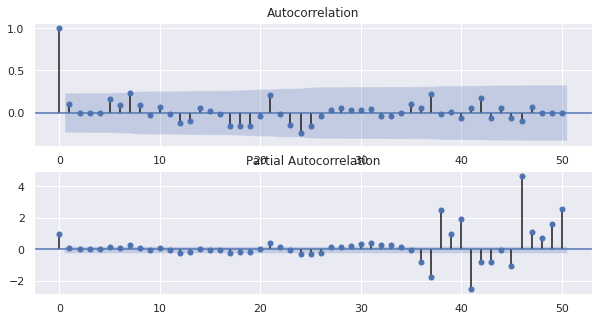

In [ ]:
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)
test_adf(forecastData)
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()


### Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model aka SARIMAX

Fine Tuning Seasonal Order

In [ ]:
import itertools
import warnings
warnings.filterwarnings('ignore')
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [([0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

maxx = -10
order = (0,0,0)
seasonal_order= (0,0,0,0)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False,freq=None)
            results = mod.fit()
            if maxx < results.aic:
                maxx = results.aic
                order = param
                seasonal_order = param_seasonal
                
        except: 
            continue
print(order,"x",seasonal_order) 


(0, 1, 0) x ([0], 1, 0, 12)


Training SARIMAX

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.865e+07   5.46e+05     34.124      0.000    1.76e+07    1.97e+07
26140.15078023216


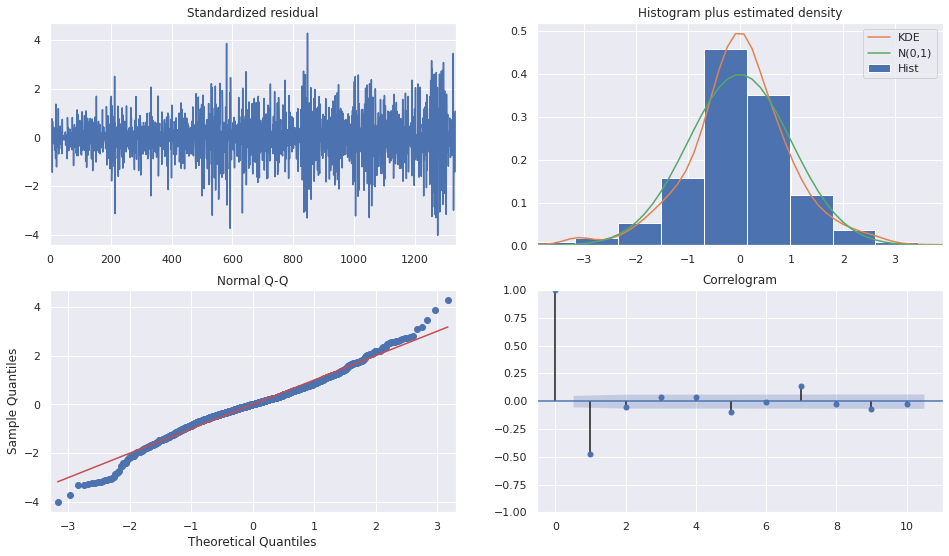

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = order,
                                seasonal_order=seasonal_order,
                                 enforce_stationarity=False, 
                                 enforce_invertibility=False#1 yıllık
                                )
results = mod.fit() 
print(results.summary().tables[1])
print(results.aic)
results.plot_diagnostics(figsize=(16,9))
plt.show()
 

Visualizing Predictions

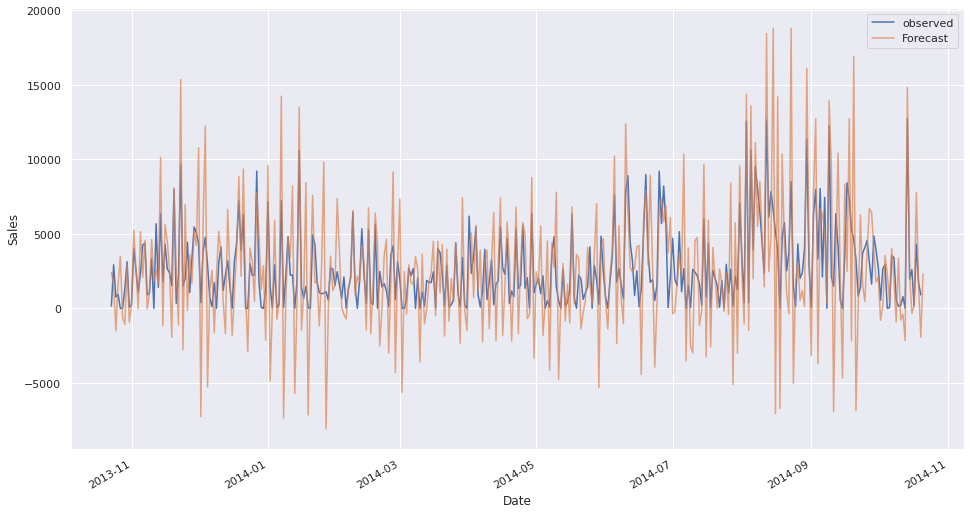

0.4572499395583106


In [ ]:
pred = results.get_prediction(start=forecastData.index[1000],end=forecastData.index[1359], dynamic=False)
pred_ci = pred.conf_int()
ax = forecastData.shift(1)[1000:1359].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(16, 9))

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()
print(r2_score(pred.predicted_mean,forecastData[999:1359]))


Forecasting

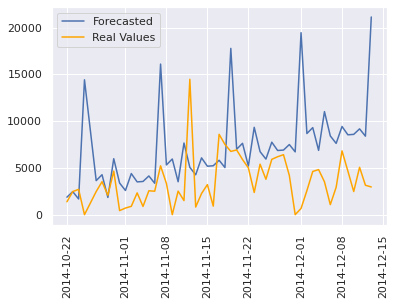

-0.9969956074614079


In [ ]:
 
# Getting 120 days (a little more than 6 months in business days) for forecasts
forecast_result = pd.DataFrame(data={"index": forecastData.index[1360:1412],"values":results.forecast(steps = 52)})
forecast_result.set_index("index",inplace=True)
plt.plot(forecast_result)
plt.plot(forecastData[1360:1412],color="orange")
plt.legend(["Forecasted","Real Values"])
plt.xticks(rotation=90)
plt.show()
print(r2_score(forecast_result.values,forecastData[1360:1412].values))
# Creating an index from 10/29/2018 to six months out, frequency indicates business day which eliminates weekends and
# US holidays, then putting it all together into a SARIMAX_forecast dataframe



### Using PROPHET Library for time-series forecasting

0.40814041133169954


<Figure size 1296x432 with 0 Axes>

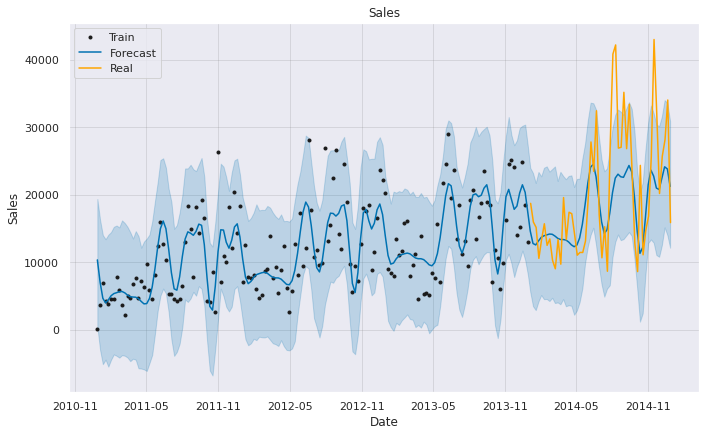

In [ ]:
#%% PROPHET

from fbprophet import Prophet

prophetData = real[:-52]
salesData = pd.DataFrame(data={'Order Date': prophetData.index, 'Sales':prophetData.values})
salesData = salesData.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

prophet_model = Prophet(interval_width=0.98,weekly_seasonality=False,daily_seasonality=False)
prophet_model.fit(salesData)


sales_forecast = prophet_model.make_future_dataframe(periods=52,freq='W')
sales_forecast = prophet_model.predict(sales_forecast)


plt.figure(figsize=(18, 6))
prophet_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')

plt.plot(real[-52:],color="orange")
plt.legend(["Train","Forecast","Real"])

plt.title('Sales');
print(r2_score(real[-52:],sales_forecast["yhat"][-52:]))



Extra Tree Regressor got the highest score with 0.78 r^2 score using Yearly Data on "EU" market